In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tensorflow.examples.tutorials.mnist import input_data

C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#Load the MNIST dataset
mnist = input_data.read_data_sets('MNIST_data/')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
class CapsConv(object):
    ''' Capsule layer.
    Args:
        input: A 4-D tensor.
        num_units: integer, the length of the output vector of a capsule.
        with_routing: boolean, this capsule is routing with the
                      lower-level layer capsule.
        num_outputs: the number of capsule in this layer.
    Returns:
        A 4-D tensor.
    '''
    def __init__(self, num_units, with_routing=True):
        self.num_units = num_units
        self.with_routing = with_routing
    def __call__(self, input, num_outputs, kernel_size=None, stride=None):
        self.num_outputs = num_outputs
        self.kernel_size = kernel_size
        self.stride = stride
        if not self.with_routing:
            #assert input.get_shape() == [None, 28,28,256]

            capsules = tf.contrib.layers.conv2d(input, self.num_outputs,
                                                self.kernel_size, self.stride, padding="VALID",
                                                activation_fn=tf.nn.relu)
            capsules = tf.reshape(capsules, (10, -1, self.num_units, 1))

            # [batch_size, 1152, 8, 1]
            capsules = squash(capsules)
            assert capsules.get_shape() == [10, 1152, 8, 1]
            return(capsules)
            
        else:
            # the DigitCap layer
            # reshape the input into shape [128,1152,8,1]
            input = tf.reshape(input, shape=(10, 1152, 8,1))
            
            #b_IJ : [1, num_caps_1, num_caps_1_plus_1, 1]
            b_IJ = tf.zeros(shape=[1,1152,10,1], dtype=np.float32)
            capsules = []
            for j in range(self.num_outputs):
                with tf.variable_scope('caps_' + str(j)):
                    caps_j, b_IJ = capsule(input, b_IJ, j)
                    capsules.append(caps_j)
            
            #return a tensor with shape [batch_size,10,16,1]
            capsules = tf.concat(capsules, axis=1)
            assert capsules.get_shape() == [10,10,16,1]
        
        return(capsules)

In [4]:
def capsule(input, b_IJ, idx_j):
    ''' The routing algorithm for one capsule in the layer l+1.
    Args:
        input: A Tensor with [batch_size, num_caps_l=1152, length(u_i)=8, 1]
               shape, num_caps_l meaning the number of capsule in the layer l.
    Returns:
        A Tensor of shape [batch_size, 1, length(v_j)=16, 1] representing the
        vector output `v_j` of capsule j in the layer l+1
    Notes:
        u_i represents the vector output of capsule i in the layer l, and
        v_j the vector output of capsule j in the layer l+1.
     '''
    with tf.variable_scope('routing'):

        w_initializer = np.random.normal(size=[1, 1152, 8, 16], scale=0.01)

        W_Ij = tf.Variable(w_initializer, dtype=tf.float32)
        sess.run(tf.global_variables_initializer())
        # repeat W_Ij with batch_size times to shape [batch_size, 1152, 8, 16]
        W_Ij = tf.tile(W_Ij, [10, 1, 1, 1])

        # calc u_hat
        # [8, 16].T x [8, 1] => [16, 1] => [batch_size, 1152, 16, 1]
        u_hat = tf.matmul(W_Ij, input, transpose_a=True)
        assert u_hat.get_shape() == [10, 1152, 16, 1]

        shape = b_IJ.get_shape().as_list()
        size_splits = [idx_j, 1, shape[2] - idx_j - 1]
        for r_iter in range(3):
            # line 4:
            # [1, 1152, 10, 1]
            c_IJ = tf.nn.softmax(b_IJ, dim=2)
            assert c_IJ.get_shape() == [1, 1152, 10, 1]

            # line 5:
            # weighting u_hat with c_I in the third dim,
            # then sum in the second dim, resulting in [batch_size, 1, 16, 1]
            b_Il, b_Ij, b_Ir = tf.split(b_IJ, size_splits, axis=2)
            c_Il, c_Ij, b_Ir = tf.split(c_IJ, size_splits, axis=2)
            assert c_Ij.get_shape() == [1, 1152, 1, 1]

            s_j = tf.multiply(c_Ij, u_hat)
            s_j = tf.reduce_sum(tf.multiply(c_Ij, u_hat),
                                axis=1, keep_dims=True)
            assert s_j.get_shape() == [10, 1, 16, 1]

            # line 6:
            # squash using Eq.1, resulting in [batch_size, 1, 16, 1]
            v_j = squash(s_j)
            assert s_j.get_shape() == [10, 1, 16, 1]

            # line 7:
            # tile v_j from [batch_size ,1, 16, 1] to [batch_size, 1152, 16, 1]
            # [16, 1].T x [16, 1] => [1, 1], then reduce mean in the
            # batch_size dim, resulting in [1, 1152, 1, 1]
            v_j_tiled = tf.tile(v_j, [1, 1152, 1, 1])
            u_produce_v = tf.matmul(u_hat, v_j_tiled, transpose_a=True)
            assert u_produce_v.get_shape() == [10, 1152, 1, 1]
            b_Ij += tf.reduce_sum(u_produce_v, axis=0, keep_dims=True)
            b_IJ = tf.concat([b_Il, b_Ij, b_Ir], axis=2)

        return(v_j, b_IJ)

In [5]:
def squash(vector):
    '''Squashing function.
    Args:
        vector: A 4-D tensor with shape [batch_size, num_caps, vec_len, 1],
    Returns:
        A 4-D tensor with the same shape as vector but
        squashed in 3rd and 4th dimensions.
    '''
    vec_abs = tf.sqrt(tf.reduce_sum(tf.square(vector)))  # a scalar
    scalar_factor = tf.square(vec_abs) / (1 + tf.square(vec_abs))
    vec_squashed = scalar_factor * tf.divide(vector, vec_abs)  # element-wise
    return(vec_squashed)

In [6]:
def discriminator(x_image, reuse=False):
    x_image.get_shape()
    if (reuse):
        tf.get_variable_scope().reuse_variables()
        
    #Carefully check the code below
    # First convolutional and pool layers
    # These search for 256 different 5 x 5 pixel features
    #We’ll start off by passing the image through a convolutional layer. 
    #First, we create our weight and bias variables through tf.get_variable. 
    #Our first weight matrix (or filter) will be of size 5x5 and will have a output depth of 256. 
    #It will be randomly initialized from a normal distribution.
    d_w1 = tf.get_variable('d_w1', [9, 9, 1, 256], initializer=tf.truncated_normal_initializer(stddev=0.02))
    #tf.constant_init generates tensors with constant values.
    d_b1 = tf.get_variable('d_b1', [256], initializer=tf.constant_initializer(0))
    
    #tf.nn.conv2d() is the Tensorflow’s function for a common convolution.
    #It takes in 4 arguments. The first is the input volume (our 28 x 28 x 1 image in this case). 
    #The next argument is the filter/weight matrix. Finally, you can also change the stride and 
    #padding of the convolution. Those two values affect the dimensions of the output volume.
    #"SAME" tries to pad evenly left and right, but if the amount of columns to be added is odd, 
    #it will add the extra column to the right,
    #strides = [batch, height, width, channels]
    d1 = tf.nn.conv2d(input=x_image, filter=d_w1, strides=[1, 1, 1, 1], padding='VALID')
    #d1 = tf.contrib.layers.conv2d(inputs=x_image, num_outputs=256,weights_initializer = d_w1,
    #                                        kernel_size=8, stride=1,padding='SAME')
    #add the bias
    d1 = d1 + d_b1
    
    #here comes the capsNet
    with tf.variable_scope('PrimaryCaps_layer'):
        primaryCaps = CapsConv(num_units=8, with_routing=False)
        caps1 = primaryCaps(d1, num_outputs=256, kernel_size=9, stride=2)
        #assert caps1.get_shape() == [128, 1152, 8, 1]

    # DigitCaps layer, [batch_size, 10, 16, 1]
    with tf.variable_scope('DigitCaps_layer'):
        digitCaps = CapsConv(num_units=16, with_routing=True)
        caps2 = digitCaps(caps1, num_outputs=10)
    
    #and then followed by a series of fully connected layers. 
    # First fully connected layer
    d_w3 = tf.get_variable('d_w3', [16*10, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
    d3 = tf.reshape(caps2, [-1, 16*10])
    d3 = tf.matmul(d3, d_w3)
    d3 = d3 + d_b3
    d3 = tf.nn.relu(d3)

    #The last fully-connected layer holds the output, such as the class scores.
    # Second fully connected layer
    d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))

    #At the end of the network, we do a final matrix multiply and 
    #return the activation value. 
    #For those of you comfortable with CNNs, this is just a simple binary classifier. Nothing fancy.
    # Final layer
    d4 = tf.matmul(d3, d_w4) + d_b4
    # d4 dimensions: batch_size x 1

    return d4

In [7]:
def generator(batch_size, z_dim): 
    z = tf.truncated_normal([batch_size, z_dim], mean=0, stddev=1, name='z')
    #first deconv block
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='bn1')
    g1 = tf.nn.relu(g1)

    # Generate 50 features
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='bn2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])

    # Generate 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='bn3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])
    
    #CapsNet Implementation
    #Masking is done by default
    '''
    #generate 50 features, requires a conv1, primary cap and digit cap
    
    #generate 25 feaures, requires a conv2, primary cap and a digit cap
    
    #masking true by default
    self.masked_v = tf.multiply(tf.squeeze(self.caps2), tf.reshape(self.Y,(-1,10,1)))
    self.v_length = tf.sqrt(tf.reduce_sum(tf.square(self.caps2), axis=2, keep_dims=True)+1e-9)
        
    '''

    # Final convolution with one output channel
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)

    # No batch normalization at the final layer, but we do add
    # a sigmoid activator to make the generated images crisper.
    # Dimensions of g4: batch_size x 28 x 28 x 1

    return g4

In [8]:
# To allocate GPU memory according to usage
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [9]:
batch_size = 10
z_dimensions = 100

In [10]:
# x_placeholder is for the input image to the discriminator
x_placeholder = tf.placeholder("float", shape=[10, 28,28,1], name='x_placeholder')

In [11]:
#generated images
Gz = generator(batch_size, z_dimensions)

In [12]:
#discriminators probability for real images
Dx = discriminator(x_placeholder)

In [13]:
with tf.variable_scope(tf.get_variable_scope()) as scope:
    pass 

In [14]:
# discriminator probability for generated images
Dg = discriminator(Gz, reuse=True)

In [15]:
#gan loss function
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels = tf.ones_like(Dg)))

d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.fill([batch_size, 1], 0.9)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))
d_loss = d_loss_real + d_loss_fake

In [16]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

In [17]:
with tf.variable_scope(scope):    
    d_trainer_fake = tf.train.AdamOptimizer(0.0001).minimize(d_loss_fake, var_list=d_vars) 
    d_trainer_real = tf.train.AdamOptimizer(0.0001).minimize(d_loss_real, var_list=d_vars) 
    g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

In [18]:
# Outputs a Summary protocol buffer containing a single scalar value.
tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)

<tf.Tensor 'Discriminator_loss_fake:0' shape=() dtype=string>

In [19]:
d_real_count_ph = tf.placeholder(tf.float32)
d_fake_count_ph = tf.placeholder(tf.float32)
g_count_ph = tf.placeholder(tf.float32)

In [20]:
tf.summary.scalar('d_real_count', d_real_count_ph)
tf.summary.scalar('d_fake_count', d_fake_count_ph)
tf.summary.scalar('g_count', g_count_ph)

<tf.Tensor 'g_count:0' shape=() dtype=string>

In [21]:
# Sanity check to see how the discriminator evaluates
# generated and real MNIST images
d_on_generated = tf.reduce_mean(discriminator(generator(batch_size, z_dimensions)))
d_on_real = tf.reduce_mean(discriminator(x_placeholder))

In [22]:
tf.summary.scalar('d_on_generated_eval', d_on_generated)
tf.summary.scalar('d_on_real_eval', d_on_real)

<tf.Tensor 'd_on_real_eval:0' shape=() dtype=string>

In [23]:
images_for_tensorboard = generator(batch_size, z_dimensions)
tf.summary.image('Generated_images', images_for_tensorboard, 10)
merged = tf.summary.merge_all()
logdir = "tensorboard/gan/"
writer = tf.summary.FileWriter(logdir, sess.graph)
print(logdir)

tensorboard/gan/


In [24]:
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

TRAINING STEP 0 AT 2018-01-12 03:17:35.248076
Discriminator classification [-1.1643089e-07]


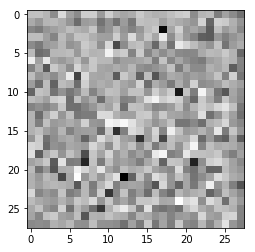

Discriminator classification [-1.14737205e-07]


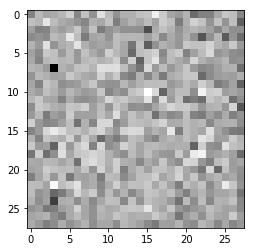

Discriminator classification [-1.1563583e-07]


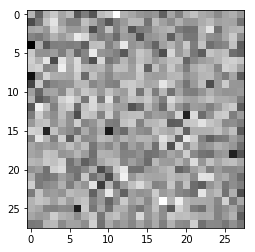

saved to models/pretrained_gan.ckpt-0
TRAINING STEP 10 AT 2018-01-12 03:18:25.349912
Discriminator classification [5.9130752e-08]


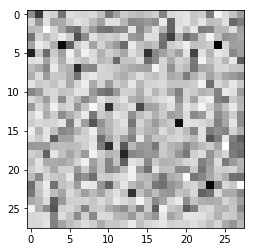

Discriminator classification [6.4017236e-08]


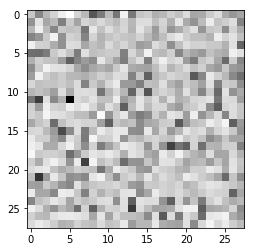

Discriminator classification [6.2312495e-08]


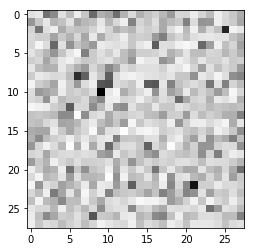

ResourceExhaustedError: OOM when allocating tensor with shape[9,9,256,256]
	 [[Node: PrimaryCaps_layer/Conv/weights/Initializer/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, _class=["loc:@PrimaryCaps_layer/Conv/weights"], dtype=DT_FLOAT, seed=0, seed2=0, _device="/job:localhost/replica:0/task:0/device:GPU:0"](PrimaryCaps_layer/Conv/weights/Initializer/random_uniform/shape)]]

Caused by op 'PrimaryCaps_layer/Conv/weights/Initializer/random_uniform/RandomUniform', defined at:
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\ipykernel\kernelapp.py", line 478, in start
    self.io_loop.start()
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\ipykernel\kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\ipykernel\kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\ipykernel\kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-b11844a30a59>", line 2, in <module>
    Dx = discriminator(x_placeholder)
  File "<ipython-input-6-37b925c22443>", line 33, in discriminator
    caps1 = primaryCaps(d1, num_outputs=256, kernel_size=9, stride=2)
  File "<ipython-input-3-2346dd0eada9>", line 24, in __call__
    activation_fn=tf.nn.relu)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\tensorflow\contrib\framework\python\ops\arg_scope.py", line 181, in func_with_args
    return func(*args, **current_args)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\tensorflow\contrib\layers\python\layers\layers.py", line 1033, in convolution
    outputs = layer.apply(inputs)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\tensorflow\python\layers\base.py", line 671, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\tensorflow\python\layers\base.py", line 559, in __call__
    self.build(input_shapes[0])
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\tensorflow\python\layers\convolutional.py", line 143, in build
    dtype=self.dtype)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\tensorflow\python\layers\base.py", line 458, in add_variable
    trainable=trainable and self.trainable)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1203, in get_variable
    constraint=constraint)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1092, in get_variable
    constraint=constraint)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 417, in get_variable
    return custom_getter(**custom_getter_kwargs)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\tensorflow\contrib\layers\python\layers\layers.py", line 1539, in layer_variable_getter
    return _model_variable_getter(getter, *args, **kwargs)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\tensorflow\contrib\layers\python\layers\layers.py", line 1531, in _model_variable_getter
    custom_getter=getter, use_resource=use_resource)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\tensorflow\contrib\framework\python\ops\arg_scope.py", line 181, in func_with_args
    return func(*args, **current_args)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\tensorflow\contrib\framework\python\ops\variables.py", line 262, in model_variable
    use_resource=use_resource)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\tensorflow\contrib\framework\python\ops\arg_scope.py", line 181, in func_with_args
    return func(*args, **current_args)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\tensorflow\contrib\framework\python\ops\variables.py", line 217, in variable
    use_resource=use_resource)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 394, in _true_getter
    use_resource=use_resource, constraint=constraint)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 805, in _get_single_variable
    constraint=constraint)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\tensorflow\python\ops\variables.py", line 213, in __init__
    constraint=constraint)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\tensorflow\python\ops\variables.py", line 303, in _init_from_args
    initial_value(), name="initial_value", dtype=dtype)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 779, in <lambda>
    shape.as_list(), dtype=dtype, partition_info=partition_info)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\tensorflow\contrib\layers\python\layers\initializers.py", line 144, in _initializer
    dtype, seed=seed)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\tensorflow\python\ops\random_ops.py", line 240, in random_uniform
    shape, dtype, seed=seed1, seed2=seed2)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\tensorflow\python\ops\gen_random_ops.py", line 472, in _random_uniform
    name=name)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "C:\Users\husey_000\Miniconda3\envs\capsule-gans\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[9,9,256,256]
	 [[Node: PrimaryCaps_layer/Conv/weights/Initializer/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, _class=["loc:@PrimaryCaps_layer/Conv/weights"], dtype=DT_FLOAT, seed=0, seed2=0, _device="/job:localhost/replica:0/task:0/device:GPU:0"](PrimaryCaps_layer/Conv/weights/Initializer/random_uniform/shape)]]


In [25]:
#During every iteration, there will be two updates being made, one to the discriminator and one to the generator. 
#For the generator update, we’ll feed in a random z vector to the generator and pass that output to the discriminator
#to obtain a probability score (this is the Dg variable we specified earlier).
#As we remember from our loss function, the cross entropy loss gets minimized, 
#and only the generator’s weights and biases get updated.
#We'll do the same for the discriminator update. We’ll be taking a batch of images 
#from the mnist variable we created way at the beginning of our program.
#These will serve as the positive examples, while the images in the previous section are the negative ones.

gLoss = 0
dLossFake, dLossReal = 1, 1
d_real_count, d_fake_count, g_count = 0, 0, 0
for i in range(10000):
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    if dLossFake > 0.6:
        # Train discriminator on generated images
        _, dLossReal, dLossFake, gLoss = sess.run([d_trainer_fake, d_loss_real, d_loss_fake, g_loss],
                                                    {x_placeholder: real_image_batch})
        d_fake_count += 1
        

    if gLoss > 0.5:
        # Train the generator
        _, dLossReal, dLossFake, gLoss = sess.run([g_trainer, d_loss_real, d_loss_fake, g_loss],
                                                    {x_placeholder: real_image_batch})
        g_count += 1
        

    if dLossReal > 0.45:
        # If the discriminator classifies real images as fake,
        # train discriminator on real values
        _, dLossReal, dLossFake, gLoss = sess.run([d_trainer_real, d_loss_real, d_loss_fake, g_loss],
                                                    {x_placeholder: real_image_batch})
        d_real_count += 1
        

    if i % 10 == 0:
        real_image_batch = mnist.validation.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
        summary = sess.run(merged, {x_placeholder: real_image_batch, d_real_count_ph: d_real_count,
                                    d_fake_count_ph: d_fake_count, g_count_ph: g_count})
        writer.add_summary(summary, i)
        d_real_count, d_fake_count, g_count = 0, 0, 0

    if i % 10 == 0:
        # Periodically display a sample image in the notebook
        # (These are also being sent to TensorBoard every 10 iterations)
        images = sess.run(generator(10, z_dimensions))
        d_result = sess.run(discriminator(x_placeholder), {x_placeholder: images})
        print("TRAINING STEP", i, "AT", datetime.datetime.now())
        for j in range(3):
            print("Discriminator classification", d_result[j])
            im = images[j, :, :, 0]
            plt.imshow(im.reshape([28, 28]), cmap='Greys')
            plt.show()

    if i % 500 == 0:
        save_path = saver.save(sess, "models/pretrained_gan.ckpt", global_step=i)
        print("saved to %s" % save_path)
        
    
test_images = sess.run(generator(10, 100))
test_eval = sess.run(discriminator(x_placeholder), {x_placeholder: test_images})

real_images = mnist.validation.next_batch(10)[0].reshape([10, 28, 28, 1])
real_eval = sess.run(discriminator(x_placeholder), {x_placeholder: real_images})

# Show discriminator's probabilities for the generated images,
# and display the images
for i in range(10):
    print(test_eval[i])
    plt.imshow(test_images[i, :, :, 0], cmap='Greys')
    plt.show()

# Now do the same for real MNIST images
for i in range(10):
    print(real_eval[i])
    plt.imshow(real_images[i, :, :, 0], cmap='Greys')
    plt.show()